In [1]:
# import torchvision
import matplotlib.pyplot as plt
import os
import re
import timm
import torch
import torchinfo
import torch.nn as nn
import visualtorch

from collections import defaultdict, OrderedDict
from torchview import draw_graph
from torchvision.models import resnet50
from torchviz import make_dot
from transformers import ViTModel

from local_python.general_utils import load_model, print_parameters

os.environ["PATH"] += os.pathsep + "C:/PetersPrograms/Graphviz/bin/"

c:\workspace\thesis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [132]:
# image_shape = torch.Size([3, 224, 224])
max_depth = 2
resnet_path = "../runs/temp_model_body.txt"
resnet_path_2 = "../runs/temp_model_body_2.txt"
vit_path = "../runs/temp_model_body_3.txt"
vit_path_2 = "../runs/temp_model_body_4.txt"
background_fill=(0, 0, 0, 0)

In [192]:
# make_dot(output.mean(), params=dict(model.named_parameters()))

In [225]:
original_function = visualtorch.graph._draw_connector

In [291]:
def adjusted_method(draw, start_node, end_node, color, width):
    # skip non-horizontal connections to yellow layers
    if (end_node._fill == (255, 242, 204, 255)) and (start_node.y1 != end_node.y1):
        return
    return original_function(draw, start_node, end_node, color, width)
visualtorch.graph._draw_connector = adjusted_method

In [308]:
input_shape = (1, 4)
model = nn.Sequential(
    nn.Linear(4, 6),
    nn.ReLU(),
    nn.Linear(6, 6),
    nn.ReLU(),
    nn.Linear(6, 3),
    nn.Sigmoid(),
    nn.Conv1d(1, 3, kernel_size=1, padding=0), # Workaround to color output
)

In [294]:
color_map: dict = defaultdict(dict)
color_map[None]["fill"] = "#DEEBF7"
color_map[None]["outline"] = "#2F5597"
color_map[nn.Linear]["fill"] = "#E2F0D9"
color_map[nn.Linear]["outline"] = "#548235"
color_map[nn.Conv2d]["fill"] = "#FFF2CC" # Conv1d and Conv2d share the same grad_fn name
color_map[nn.Conv2d]["outline"] = "#BF9000"

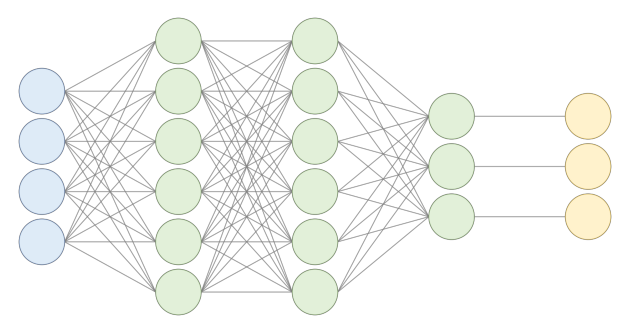

In [309]:
zoom = 2 # increase for better resolutions
img = visualtorch.graph_view(
    model,
    input_shape,
    color_map=color_map,
    background_fill=background_fill,
    to_file="../images/mlp_architecture.png",
    node_size=zoom*50,
    padding=zoom*10,
    layer_spacing=zoom*100,
    # ellipsize_after=50,
    # connector_width=1,
    # connector_fill="black"
)
plt.axis("off")
plt.tight_layout()
plt.imshow(img)
plt.show()

In [315]:
input_shape = (1, 3, 224, 224)
model = nn.Sequential(
    # nn.Identity(),
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(16, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(64 * 28 * 28, 256),
    nn.ReLU(),
    nn.Linear(256, 10),  # Assuming 10 output classes
)

In [63]:
torchinfo.summary(model, input_shape[1:], batch_dim=0)

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 16, 224, 224]         448
├─ReLU: 1-2                              [1, 16, 224, 224]         --
├─MaxPool2d: 1-3                         [1, 16, 112, 112]         --
├─Conv2d: 1-4                            [1, 32, 112, 112]         4,640
├─ReLU: 1-5                              [1, 32, 112, 112]         --
├─MaxPool2d: 1-6                         [1, 32, 56, 56]           --
├─Conv2d: 1-7                            [1, 64, 56, 56]           18,496
├─ReLU: 1-8                              [1, 64, 56, 56]           --
├─MaxPool2d: 1-9                         [1, 64, 28, 28]           --
├─Flatten: 1-10                          [1, 50176]                --
├─Linear: 1-11                           [1, 256]                  12,845,312
├─ReLU: 1-12                             [1, 256]                  --

In [338]:
color_map: dict = defaultdict(dict)
# color_map[None]["fill"] = "#DEEBF7"
# color_map[None]["outline"] = "#2F5597"
# color_map[nn.None]["fill"] = "#EDEDED"
# color_map[nn.None]["outline"] = "#7C7C7C"
# color_map[nn.None]["fill"] = "#D0CECE"
# color_map[nn.None]["outline"] = "#3B3838"
color_map[nn.Linear]["fill"] = "#E2F0D9"
color_map[nn.Linear]["outline"] = "#548235"
color_map[nn.MaxPool2d]["fill"] = "#FBE5D6"
color_map[nn.MaxPool2d]["outline"] = "#C55A11"
color_map[nn.Flatten]["fill"] = "#FFF2CC"
color_map[nn.Flatten]["outline"] = "#BF9000"
color_map[nn.Conv2d]["fill"] = "#DEEBF7"
color_map[nn.Conv2d]["outline"] = "#2F5597"

ignored_layers = [nn.ReLU]  # , nn.Flatten, nn.Sequential

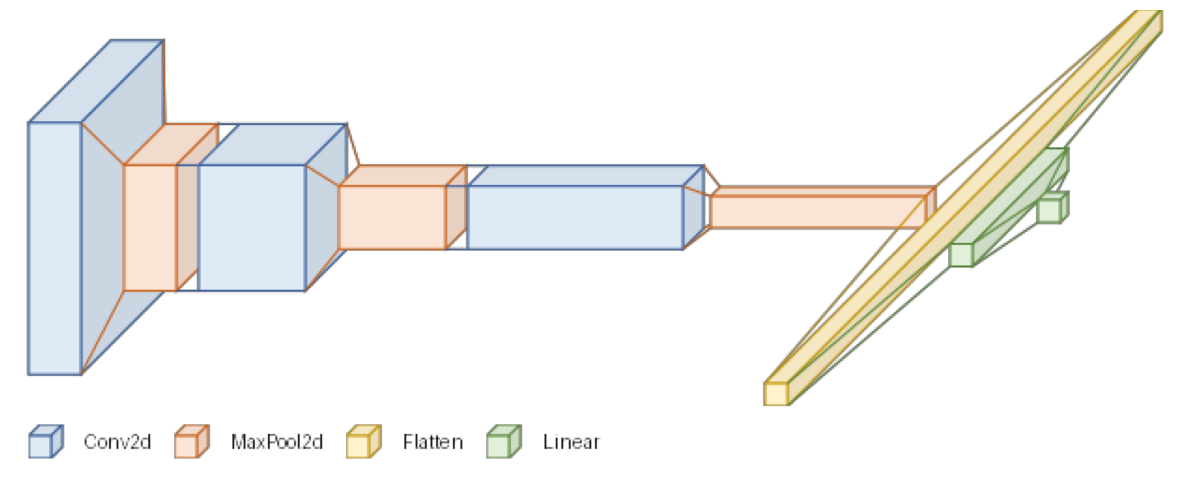

In [342]:
zoom = 0.6
img = visualtorch.layered_view(
    model,
    input_shape=input_shape,
    # draw_volume=False,
    background_fill=background_fill,
    legend=True,
    min_z=zoom * 20,
    # max_z=zoom*7,
    min_xy=zoom * 20,
    max_xy=zoom * 1000,
    scale_z=zoom * 3,
    scale_xy=zoom * 1,
    # index_ignore=index_list,
    color_map=color_map,
    type_ignore=ignored_layers,
    one_dim_orientation="x",
    spacing=int(zoom * 20),
    to_file="../images/cnn_architecture.png",
)

plt.figure(figsize=(12, 5))
plt.axis("off")
plt.tight_layout()
plt.imshow(img)
plt.show()


(process:18032): Pango-WARNING **: 17:07:10.893: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


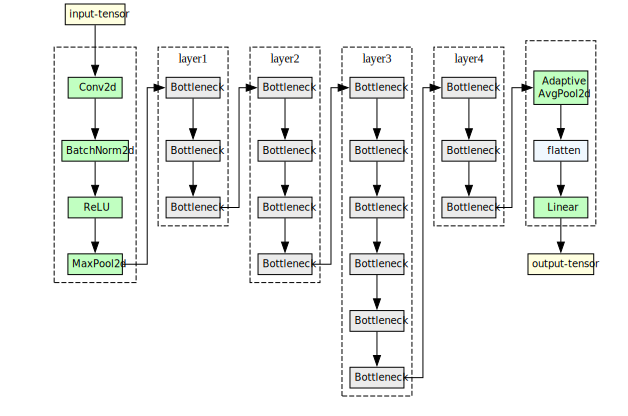

In [98]:
model_graph = draw_graph(
    nn.Sequential(),
    input_size=input_shape,
    expand_nested=True,
    depth=2,
    show_shapes=False,
)
with open(resnet_path, "r") as temp_file:
    model_graph.visual_graph.body = temp_file.readlines()

model_graph.visual_graph


(process:16584): Pango-WARNING **: 17:00:42.241: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


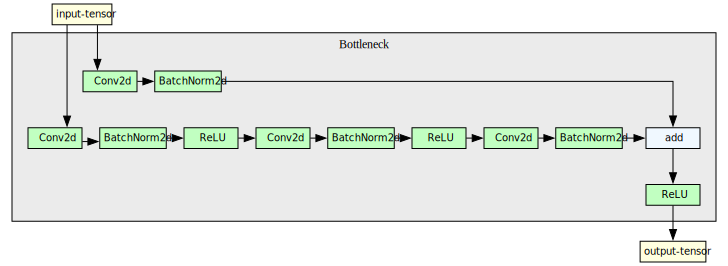

In [87]:
model_graph = draw_graph(
    nn.Sequential(),
    input_size=input_shape,
    expand_nested=True,
    depth=2,
    show_shapes=False,
)
model_graph.visual_graph.graph_attr["rankdir"] = "TB"
with open(resnet_path_2, "r") as temp_file:
    model_graph.visual_graph.body = temp_file.readlines()
# model_graph.add_edge(["cluster_2",25], 1)
# model_graph.resize_graph(scale=5.0) # scale as per the view
# model_graph.visual_graph.render(format='svg')

model_graph.visual_graph


(process:15388): Pango-WARNING **: 17:00:52.066: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


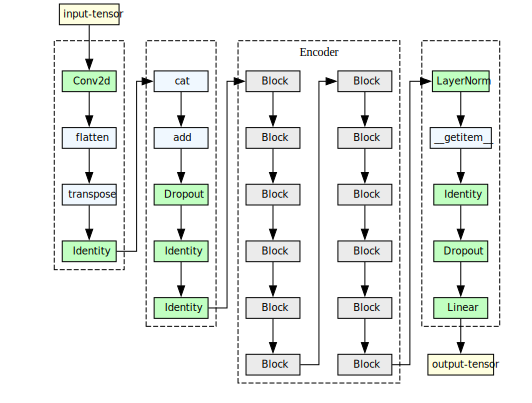

In [88]:
model_graph = draw_graph(
    nn.Sequential(),
    input_size=input_shape,
    expand_nested=True,
    depth=2,
    show_shapes=False,
)
with open(vit_path, "r") as temp_file:
    model_graph.visual_graph.body = temp_file.readlines()

model_graph.visual_graph


(process:7940): Pango-WARNING **: 01:56:02.683: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


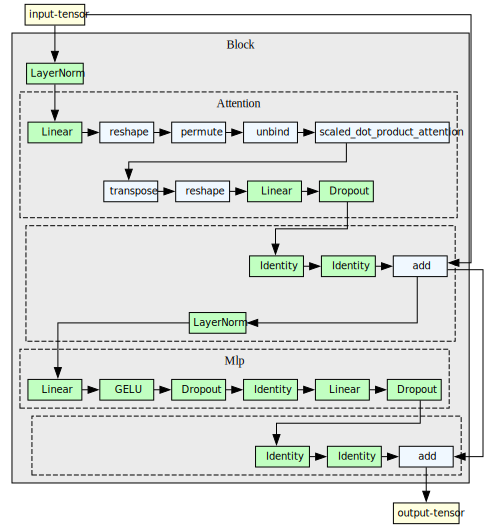

In [300]:
model_graph = draw_graph(
    nn.Sequential(),
    input_size=input_shape,
    expand_nested=True,
    depth=2,
    show_shapes=False,
)
with open(vit_path_2, "r") as temp_file:
    model_graph.visual_graph.body = temp_file.readlines()

model_graph.visual_graph

In [313]:
input_shape = (1, 3, 224, 224)
model = resnet50(weights=None)
# random_input = torch.rand(*input_shape)
# output = model(random_input)
# output.shape

In [314]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [247]:
model_graph = draw_graph(
    model,
    input_size=input_shape,
    expand_nested=True,
    depth=1,
    show_shapes=False,
    graph_dir="LR",
)
model_graph.visual_graph


(process:14156): Pango-WARNING **: 17:23:09.331: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.



(process:9200): Pango-WARNING **: 17:55:54.201: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


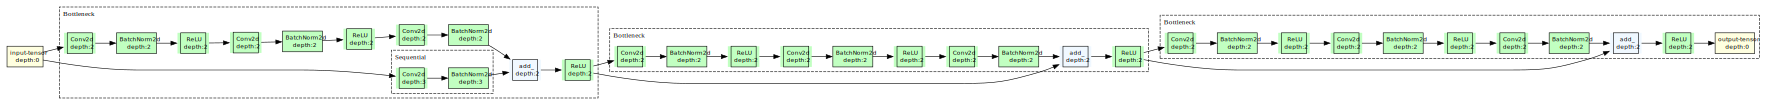

In [287]:
model_graph = draw_graph(
    model.layer1,
    input_size=(64, 64, 1, 1),
    expand_nested=True,
    # depth=2,
    show_shapes=False,
    graph_dir="LR",
)
# model_graph.visual_graph.body = ['nodesep="0"', *model_graph.visual_graph.body]
model_graph.visual_graph

# with open(temp_path+"_2", "w") as temp_file:
#     temp_file.write("\n".join([entry.replace('\r', '').replace('\n', '') for entry in model_graph.visual_graph.body]))

In [259]:
raw_path = "../model_weights/resnet50/plant_sl.pth"
checkpoint = torch.load(raw_path, map_location=torch.device("cpu"), weights_only=False)
model.fc = nn.Sequential()
model.load_state_dict(checkpoint)
print_parameters(model)

Trainable parameters: 23508032/23508032


In [140]:
model = timm.create_model("vit_tiny_patch16_224", pretrained=False)

In [355]:
model_graph = draw_graph(
    model,
    input_size=input_shape,
    expand_nested=True,
    depth=1,
    show_shapes=False,
    graph_dir="LR",
)
model_graph.visual_graph


(process:4100): Pango-WARNING **: 01:04:32.478: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


In [8]:
model_graph = draw_graph(
    model,
    input_size=input_shape,
    expand_nested=True,
    depth=5,
    show_shapes=False,
    graph_dir="LR",
)
model_graph.visual_graph


(process:18348): Pango-WARNING **: 15:49:37.856: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


In [230]:
raw_path = "../model_weights/vit_t16_v2/model_best 1.pth"
checkpoint = torch.load(raw_path, map_location=torch.device("cpu"), weights_only=False)
print(checkpoint.keys())

dict_keys(['arch', 'epoch', 'student', 'teacher', 'optimizer', 'config', 'loss'])


In [125]:
model_dir = "../model_weights/vit_t16_v2/plant_ssl_student.pth"
if os.path.exists(model_dir):
    print(f"File {model_dir} already exists")
else:
    target_dict = OrderedDict()
    for key, value in checkpoint["student"].items():
        if key.startswith("head"):
            continue
        target_dict[key] = value
    print(f"Saving {len(target_dict)} keys")
    torch.save(target_dict, model_dir)

model_dir = "../model_weights/vit_t16_v2/plant_ssl_teacher.pth"
if os.path.exists(model_dir):
    print(f"File {model_dir} already exists")
else:
    target_dict = OrderedDict()
    for key, value in checkpoint["teacher"].items():
        if key.startswith("head"):
            continue
        target_dict[key] = value
    print(f"Saving {len(target_dict)} keys")
    torch.save(target_dict, model_dir)

File ../model_weights/vit_t16_v2/plant_ssl_student.pth already exists
File ../model_weights/vit_t16_v2/plant_ssl_teacher.pth already exists


In [141]:
model = load_model(model_dir, use_ssl_library=False)

Loading vit_tiny_patch16_224 from timm-library
Ignoring prefix 'backbone.'


In [147]:
summary = torchinfo.summary(model, input_shape[1:], batch_dim=0)


(process:8672): Pango-WARNING **: 18:06:57.531: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


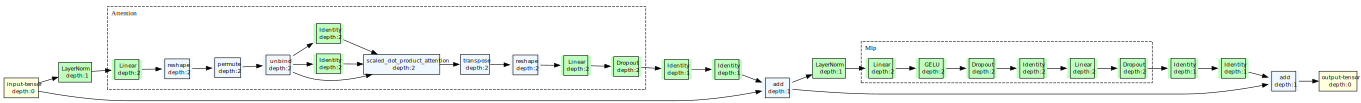

In [163]:
model_graph = draw_graph(
    model.blocks[0],
    input_size=summary.summary_list[8].input_size,
    expand_nested=True,
    depth=5,
    show_shapes=False,
    graph_dir="LR",
)
model_graph.visual_graph

In [164]:
path = vit_path_2
if not os.path.exists(path):
    for i in range(len(model_graph.visual_graph.body)):
        entry = model_graph.visual_graph.body[i]
        entry = re.sub(r"<BR/>depth:\d+</TD>", "</TD>", entry)
        # print(entry)
        model_graph.visual_graph.body[i] = entry
    with open(path, "w") as temp_file:
        temp_file.write(
            "\n".join(
                [
                    entry.replace("\r", "").replace("\n", "")
                    for entry in model_graph.visual_graph.body
                ]
            )
        )

In [11]:
model = ViTModel.from_pretrained("WinKawaks/vit-tiny-patch16-224")

Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



(process:9016): Pango-WARNING **: 15:53:48.586: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


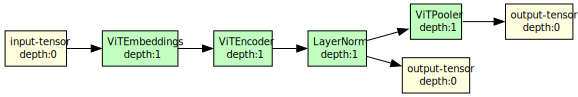

In [12]:
model_graph = draw_graph(
    model,
    input_size=input_shape,
    expand_nested=True,
    depth=1,
    show_shapes=False,
    graph_dir="LR",
)
model_graph.visual_graph

In [14]:
model_graph = draw_graph(
    model,
    input_size=input_shape,
    expand_nested=True,
    depth=7,
    show_shapes=False,
    graph_dir="LR",
)
model_graph.visual_graph


(process:9268): Pango-WARNING **: 15:56:56.532: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


In [393]:
# random_input = torch.rand(*input_shape)
# output = model(random_input)
# output.shape
# make_dot(output, params=dict(model.named_parameters()))


(process:17444): Pango-WARNING **: 11:19:57.518: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


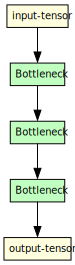

In [223]:
model_graph = draw_graph(
    model.layer1,
    input_size=(64, 64, 1, 1),
    expand_nested=True,
    depth=1,
    show_shapes=False,
    # graph_dir="LR",
    # hide_inner_tensors=True,
    # hide_module_functions=True,
)
model_graph.visual_graph


# Sequential -> name
# rotate certain elements

In [132]:
class PlaceholderLayer(nn.Module):
    def __init__(self, original: nn.Module = None) -> None:
        super().__init__()
        self.original = original

    def forward(self, x):
        if self.original:
            return self.original.forward(x)
        else:
            return x


class PlaceholderLayer1(PlaceholderLayer):
    pass


class PlaceholderLayer2(PlaceholderLayer):
    pass


class PlaceholderLayer3(PlaceholderLayer):
    pass


class PlaceholderLayer4(PlaceholderLayer):
    pass


model.layer1 = PlaceholderLayer1(
    model.layer1
)  # nn.Sequential(PlaceholderLayer1(), model.layer1)
model.layer2 = PlaceholderLayer2(
    model.layer2
)  # nn.Sequential(PlaceholderLayer2(), model.layer2)
model.layer3 = PlaceholderLayer3(
    model.layer3
)  # nn.Sequential(PlaceholderLayer3(), model.layer3)
model.layer4 = PlaceholderLayer4(
    model.layer4
)  # nn.Sequential(PlaceholderLayer4(), model.layer4)

In [126]:
index_list = [
    i for i in range(187) if i not in [0, 1, 2, 3, 36, 79, 142, 175, 176, 177]
]

In [ ]:
summary = torchinfo.summary(model, input_shape, batch_dim=0)

In [120]:
index_list = []
idx = -2
for layer in summary.summary_list:
    if layer.class_name == "Sequential":
        continue
    idx += 1
    if max_depth < layer.depth:
        index_list.append(idx)
    else:
        print(f"{idx} {layer.get_layer_name(show_var_name=False, show_depth=False)}")
print(f"Ignore {len(index_list)}/{len(summary.summary_list)} layers")

-1 ResNet
0 Conv2d
1 BatchNorm2d
2 ReLU
3 MaxPool2d
4 PlaceholderLayer1
37 PlaceholderLayer1
80 PlaceholderLayer1
143 PlaceholderLayer1
176 AdaptiveAvgPool2d
177 Linear
Ignore 168/187 layers


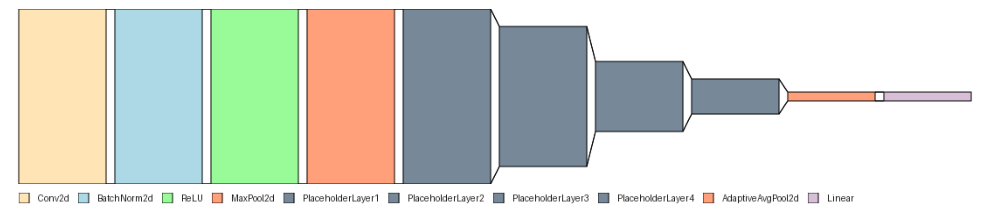

In [140]:
ignored_layers = [nn.ReLU]  # , nn.Flatten, nn.Sequential
color_map: dict = defaultdict(dict)
color_map[PlaceholderLayer1]["fill"] = "LightSlateGray"  # Light Slate Gray
color_map[PlaceholderLayer2]["fill"] = "LightSlateGray"  # Light Slate Gray
color_map[PlaceholderLayer3]["fill"] = "LightSlateGray"  # Light Slate Gray
color_map[PlaceholderLayer4]["fill"] = "LightSlateGray"  # Light Slate Gray

img = visualtorch.layered_view(
    model,
    input_shape=input_shape,
    draw_volume=False,
    legend=True,
    min_z=10,
    max_z=100,
    min_xy=10,
    max_xy=200,
    scale_z=100,
    scale_xy=10,
    index_ignore=index_list,
    color_map=color_map,
    # type_ignore=ignored_layers
)

plt.figure(figsize=(10, 3))
plt.axis("off")
plt.tight_layout()
plt.imshow(img)
plt.show()

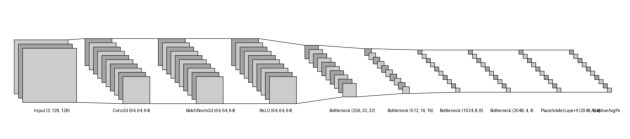

In [135]:
img = visualtorch.lenet_view(
    model,
    input_shape=input_shape,
    index_ignore=index_list,
    max_channels=10,
)

plt.axis("off")
plt.tight_layout()
plt.imshow(img)
plt.show()